# Vendedor Viajero - Colonia de Hormigas

## Importación de librerías y paquetes necesarios.



In [ ]:
from matplotlib import animation, rc, pyplot as plt
from IPython.display import HTML
from PIL import Image
import numpy as np
import time
import warnings
import urllib

## Implementación del algoritmo de optimización bajo el método de la colonia de hormigas.

In [ ]:
# Tomado de: https://github.com/johnberroa?tab=repositories

warnings.filterwarnings("ignore")

class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0, beta_evaporation_rate=0,
                 choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_evaporation_rate: rate at which beta decays (optional)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\nNumber of ants:\t\t\t\t{}".format(self.ants)
        string += "\nEvaporation rate:\t\t\t{}".format(self.evaporation_rate)
        string += "\nIntensification factor:\t\t{}".format(self.pheromone_intensification)
        string += "\nAlpha Heuristic:\t\t\t{}".format(self.heuristic_alpha)
        string += "\nBeta Heuristic:\t\t\t\t{}".format(self.heuristic_beta)
        string += "\nBeta Evaporation Rate:\t\t{}".format(self.beta_evaporation_rate)
        string += "\nChoose Best Percentage:\t\t{}".format(self.choose_best)
        string += "\n--------------------"
        string += "\nUSAGE:"
        string += "\nNumber of ants influences how many paths are explored each iteration."
        string += "\nThe alpha and beta heuristics affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\nBeta evaporation reduces the influence of the heuristic over time."
        string += "\nChoose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
                self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node, self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=50, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose: print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[0] # Definimos el nodo 0 como el nodo inicial.
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose: print("Best score at iteration {}: {}; overall: {} ({}s)"
                              "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                        round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose: print(
                "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")

    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.evaporation_rate, self.pheromone_intensification, self.heuristic_alpha,
                        self.heuristic_beta, self.beta_evaporation_rate, self.choose_best, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(np.round(self.best, 2)))
            plt.show()




## Creación del mapa de costos.

El mapa de costos consiste en una matriz que representa al costo final de trasladarse de un lugar a otro, este costo incluye, el gasto de combustible, el precio de los peajes y el salario del viajero.

In [ ]:
# Se carga la matriz de distancias:
distancias = np.loadtxt("https://raw.githubusercontent.com/JavierDarioE/Simulacion_Misc/main/distancias.csv",
                 delimiter=",")
display(distancias)


array([[   0.,  401.,   79.,  438.,  194.,  165.,  241., 1102.,  806.,
        1234., 1031., 1237.,  401.,  752.,  945.],
       [ 401.,    0.,  467.,  845.,  582.,  559.,  424., 1493., 1203.,
        1623., 1434., 1631.,  802., 1140., 1329.],
       [  79.,  467.,    0.,  361.,  118.,   88.,  170., 1031.,  726.,
        1156.,  961., 1165.,  329.,  674.,  865.],
       [ 438.,  845.,  361.,    0.,  318.,  282.,  302.,  867.,  832.,
         995., 1050.,  979.,  443.,  407.,  557.],
       [ 194.,  582.,  118.,  318.,    0.,   48.,   54.,  913.,  621.,
        1042.,  849., 1050.,  215.,  559.,  747.],
       [ 165.,  559.,   88.,  282.,   48.,    0.,   39.,  949.,  663.,
        1082.,  903.,  968.,  268.,  594.,  804.],
       [ 241.,  424.,  170.,  302.,   54.,   39.,    0.,  860.,  600.,
         993.,  831.,  894.,  194.,  508.,  694.],
       [1102., 1493., 1031.,  867.,  913.,  949.,  860.,    0.,  433.,
         296.,  365.,  295.,  745.,  449.,  525.],
       [ 806., 1203.,  7

In [ ]:
 # Se carga la matriz de costo en peajes:
peajes = np.loadtxt("https://raw.githubusercontent.com/JavierDarioE/Simulacion_Misc/main/peajes.csv",
                 delimiter=",")
display(peajes)

array([[     0.,  46600.,  27500.,  99600.,  49600.,  47900.,  75700.,
        160000., 170300., 213900., 203600., 175900.,  93000., 122800.,
        140100.],
       [ 46600.,      0.,  55900., 133900.,  80300.,  78500., 104700.,
        183400., 199200., 233500., 229500., 222200., 122500., 156000.,
        171100.],
       [ 27500.,  55900.,      0., 144200.,  22100.,  40800.,  57300.,
        141600., 142800., 186400., 183400., 267800.,  74600., 328900.,
        129500.],
       [ 99600., 133900., 144200.,      0.,  70700.,  55400.,  45400.,
        103700., 137900., 139000., 130800., 142500.,  74800.,  55100.,
         42600.],
       [ 49600.,  80300.,  22100.,  70700.,      0.,  15300.,  24400.,
        103100., 118900., 164300., 149200., 141900.,  42200.,  75700.,
         90800.],
       [ 47900.,  78500.,  40800.,  55400.,  15300.,      0.,  39700.,
        100000., 134200., 138100., 164500., 138800.,  57500.,  72600.,
         87700.],
       [ 75700., 104700.,  57300.,  4540

Se declaran algunas constantes como lo son: el costo del galón de gasolina, el costo de la hora del vendedor, la velocidad promedio de viaje y el consumo del vehículo (en gal/km).

In [ ]:
consumoKwid = 1/85 # Consumo en galones por km del renault kwid.
galonGasolina = 10766 # Precio del galón de gasolina.
velPromedio = 75 # velocidad promedio a la que se conducirá el vehículo.
horaVendedor = 4873 # Salario por hora del vendedor.

Realizamos todas las operaciones de matrices necesarias para unificar todos los costos del viaje que debe realizar el vendedor.

In [ ]:
galones = distancias * consumoKwid # Es la cantidad de galones consumidos por cada una de las distancias teniendo en cuenta el consumo del renault Kwid
costoGasolina = galones * galonGasolina # Es el costo en gasolina del trayecto por cada distancia
costoViaje = costoGasolina + peajes # Es el costo de la gasolina por cada trayecto más el valor total de los peajes entre cada ciudad
sueldoVendedor = (distancias/velPromedio) * horaVendedor # Es el tiempo que se tarda en recorrer cada trayecto a una velocidad promedio de 75 km/hora multiplicado por el valor de la hora del vendedor
costoTotal = costoViaje + sueldoVendedor

## Optimización de la ruta.
Realizamos la optimización con colonia de hormigas, buscamos la mejor ruta y el menor costo.

In [ ]:
# Asignación de la matriz con los costos entre cada ciudad a la variable map
map = costoTotal

# Crear una instancia del optimizador de colonia de hormigas
optimizer = AntColonyOptimizer(ants=100, evaporation_rate=0.1, intensification=2.0, alpha=1.0, beta=1.0, choose_best=0.1)

# Asignar la matriz de distancias al optimizador
optimizer.map = map

# Inicializar el optimizador
optimizer._initialize()

# Ejecutar el algoritmo de optimización
optimizer.fit(map, mode='min', verbose=False) # Buscamos minimizar

# Obtener la mejor ruta y la distancia mínima
best_path = optimizer.best_path
cost = optimizer.best

# Imprimir la mejor ruta y la distancia mínima
print("Mejor Camino:", best_path)
print("Costo del viaje:", cost)

Stopping early due to 50 iterations of the same score.
Mejor Camino: [0, 2, 5, 4, 3, 14, 13, 7, 11, 9, 10, 8, 12, 6, 1, 0]
Costo del viaje: 1390357.8721568626


## Histograma de resultados:
Se realiza la optimización 20 veces, con los costos minimos obtenidos se onstruye un histograma que nos muestra la distribución de los costos.

In [ ]:
def optimize_n_times(n, map, evap_rate=0.1):
  results = []
  optimizer = AntColonyOptimizer(ants=100, evaporation_rate=evap_rate, intensification=2.0, alpha=1.0, beta=1.0, choose_best=0.1)
  optimizer.map = map
  while n>0:
    optimizer._initialize()
    optimizer.fit(map, mode='min', verbose=False)
    cost = optimizer.best
    results.append(cost)
    n-=1
  return results

n_simuls = optimize_n_times(20, costoTotal)
print(n_simuls)

Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping early due to 50 iterations of the same score.
Stopping e

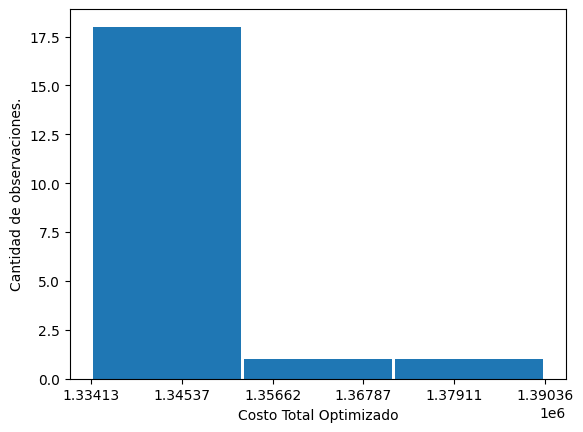

In [ ]:
tick_max=max(n_simuls)
ticks = []
ticks.append(min(n_simuls))
for i in range(1,6):
  ticks.append(ticks[i-1]+(tick_max-ticks[0])/5)
plt.hist(n_simuls, bins=3, rwidth=0.98)
plt.xticks(ticks)
#plt.title("Histograma de costos para 20 ejecuciones del optimizador.")
plt.xlabel("Costo Total Optimizado")
plt.ylabel("Cantidad de observaciones.")
plt.show()

## Gráfica y Animación del camino óptimo.


In [ ]:
# Convertir la lista con las ciudades recorridas en orden a una lista los números en texto
ciudades = [str(i) for i in best_path]

# Coordenadas de las ciudades
# Enlace de coordenadas: https://www.geodatos.net/coordenadas/colombia/palmira

coordenadas = {
    "0": [3.53944, -76.30361], # Palmira
    "1": [1.21361, -77.28111], # Pasto
    "2": [4.08466, -76.19536], # Tulúa
    "3": [4.60971, -74.08175], # Bogotá
    "4": [4.81333, -75.69611], # Pereira
    "5": [4.53389, -75.68111], # Armenia
    "6": [5.06889, -75.51738], # Manizales
    "7": [10.46314, -73.25322], # Valledupar
    "8": [8.74798, -75.88143], # Monteria
    "9": [10.71843, -74.76459], # Soledad
    "10": [10.39972, -75.51444], # Cartagena
    "11": [10.96854, -74.78132], # Barranquilla
    "12": [6.25184, -75.56359], # Medellin
    "13": [7.12539, -73.1198], # Bucaramanga
    "14": [7.89391, -72.50782] # Cucuta
  }

nombres = {
    "0": 'Palmira',
    "1": 'Pasto',
    "2": 'Tulúa',
    "3": 'Bogotá',
    "4": 'Pereira',
    "5": 'Armenia',
    "6": 'Manizales',
    "7": 'Valledupar',
    "8": 'Monteria',
    "9": 'Soledad',
    "10": 'Cartagena',
    "11": 'Barranquilla',
    "12": 'Medellin',
    "13":'Bucaramanga',
    "14": 'Cucuta'
  }

costo: 1390357.8721568626


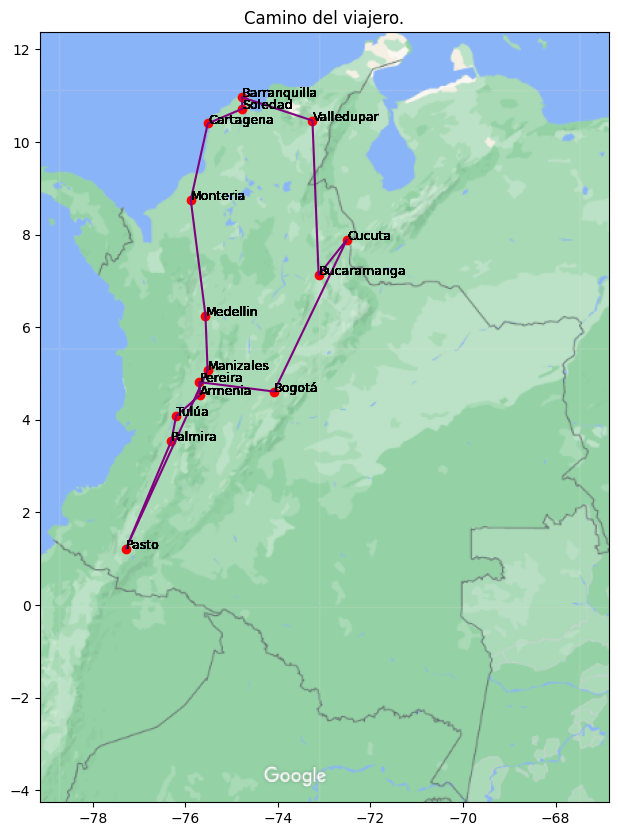

In [ ]:
BBox = (-79.13587,   -66.85109,      
        -4.2622, 12.37014)
fig, ax = plt.subplots(figsize=(11,10))
#ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.2, c='b', s=10)
x = [ciudad[1] for ciudad in coordenadas.values()]
y = [ciudad[0] for ciudad in coordenadas.values()]
ruta_x = [coordenadas[ciudad][1] for ciudad in ciudades]
ruta_y = [coordenadas[ciudad][0] for ciudad in ciudades]
urllib.request.urlretrieve("https://github.com/crjahe26/RNAyAlgoritmosBioInspiradosEquipo10/raw/main/Trabajo%2001%20-%20Optimizaci%C3%B3n%20heur%C3%ADstica/misc/Map_1.png", "map.png")
#img = Image.open("map.png")
ruh_m = plt.imread("./map.png")
ax.set_title('Camino del viajero.')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox)
ax.scatter(x,y, color="red")
for i in coordenadas.values():
  for i, txt in nombres.items():
    ax.annotate(txt, (x[int(i)], y[int(i)]), size=9)

plot, = ax.plot(ruta_x, ruta_y, color='purple')
print("costo:",optimizer.best)

In [ ]:
def init():
    plot.set_data([],[])
    return (plot,)

def animate(i):
    x_points = ruta_x[0:i]
    y_points = ruta_y[0:i]
    plot.set_data(x_points, y_points)
    return (plot,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ruta_x)+1, interval=1000, blit=True)
HTML(anim.to_html5_video())